# Noise Shaping
This tutorial covers how one can can create random noise that follows the extracted data distribution.
The extraction process is described in the Methods section of the paper, but the fitting function parameter
is available, so please refer to the Methods section to extract the noise shape from your own distribution.

## Load Libraries

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd()) + "/../src")

import EMCrafter
from EMCrafter.noise import NoiseFit, NoiseShaper
from EMCrafter.utils import circular_mask
EMCrafter.base._set_logging(minimal=True)

## Extract noise from dataset
To extract noise from your dataset, either select particles with a clean background around the particle or simply crop empty spaces in your micrograph. These should be, again, in the STAR format file. We prepared and example of only 2 particles to materialize the tutorial (but use as many as possible).

In [2]:
# star file containing images to collect noise shape (only 2 here)
particles_file = "../TUTORIAL/data/exp_particles/particles_nshape.star"

# Initialize NoiseFit class
nfit = NoiseFit(particles_file, verbose=2)

NoiseFit initialized


In [3]:
# base folder that links to the particle files dataset folders
# check your cryoSPARC or RELION to determine your base folder
base = "../TUTORIAL/data/exp_particles/"

# Load images (remember that this will read all images in memory),
# use arguments such as 'n' to set the number of images to load or
# 'ids' to load only those where their index in the list match the ids
nfit.load_images(base)

Extracting noise distribution


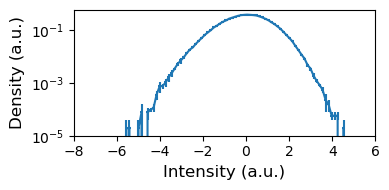

In [4]:
# Create a hard mask of radius = 120 pixels
radius, soft = 120, 0 # soft uses a gaussian filter with 'soft' pixels as the transition
imask, omask = circular_mask(nfit.image_shape, radius=radius, soft=soft)
# imask: inner circular masking
# omask: outer circular masking

# To get the noise distribution located in the outer mask (hence, excluding particle signal)
nfit.get_noise_distribution(mask=omask)
fig = nfit.plot_noise_distribution(dmin=1e-5, dmax=0.6)

### 1. Fit a gaussian PDF
$f(x) = A \cdot \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)$

Where:
- $A = \frac{1}{\sqrt{2\pi}\sigma}$ (if normalized): Amplitude
- $\mu$: Center x0
- $\sigma$: Standard deviation

Fitting noise distribution using a gaussian PDF


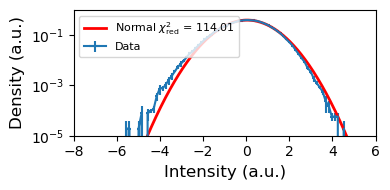

In [5]:
# Fit the distribution and plot result
nfit.fit("gaussian")
gauss_params = nfit.fit_pars.copy()
fig = nfit.plot_fit(dmin=1e-5, dmax=1.)

### 2. Fit an Exponentially Modified Gaussian
$f(x) = A \cdot \frac{\lambda}{2} \cdot \exp\left( \frac{\lambda}{2}(2\mu + \lambda \sigma^2 - 2x) \right) \cdot \operatorname{erfc} \left( \frac{\mu + \lambda \sigma^2 - x}{\sqrt{2}\sigma} \right)$

Where:
- A: Amplitude
- $\mu$: Center
- $\sigma$: Standard deviation
- $\lambda$: Exponential rate
- erfc: complementary error function.

Fitting noise distribution using a exp_mod_gaussian PDF


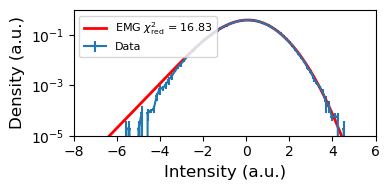

In [6]:
# Fit the distribution and plot result
nfit.fit("exp_mod_gaussian")
emg_params = nfit.fit_pars.copy()
fig = nfit.plot_fit(dmin=1e-5, dmax=1.)

### 3. Fit a Skew-Normal PDF
$f(x) = A \cdot \frac{2}{\omega} \cdot \phi\left( \frac{x - \xi}{\omega} \right) \cdot \Phi\left( \alpha \cdot \frac{x - \xi}{\omega} \right)$

Where:
- $A$: Amplitude
- $\xi$: Location (analogous to $\mu$ - center)
- $\omega$: Scale (analogous to $\sigma$ - std)
- $\alpha$: Skewness

And:
- $\phi(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}$: Standard normal PDF
- $\Phi(z) = \int_{-\infty}^{z} \phi(t) \, dt$: Standard normal CDF

Fitting noise distribution using a skew_normal PDF


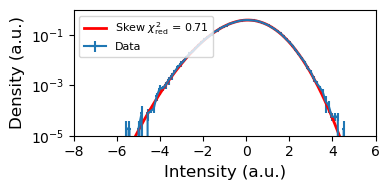

In [7]:
# Fit the distribution and plot result
nfit.fit("skew_normal")
skew_params = nfit.fit_pars.copy()
fig = nfit.plot_fit(dmin=1e-5, dmax=1.)

## Initialize Noise Shaper: Common Gaussian Noise
Now that the shape was extracted, we can use it to generate random noise that mimics experimental data

NoiseShaper initialized
Setting shape to Gaussian
Setting shape to Gaussian


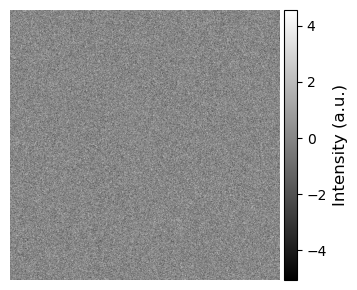

In [8]:
# By default, the Noise Shaper class initializes as a gaussian noise
# distribution centered at zero and with unit standard deviation
gauss_shaper = NoiseShaper(verbose=2)

# Instead of using default values, one can set the parameters
# directly extracted from experimental data, using:
gauss_shaper.set_gaussian_shape(*gauss_params)

# To create the noise sample, call:
sample = gauss_shaper.sample(
    shape = (480,480),         # Image shape
    n = 1                      # Number of images
)

# To check the noise image:
fig = gauss_shaper.plot_image(index=0) # index is used in case n > 1

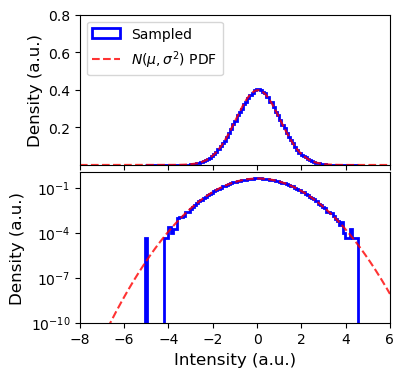

In [9]:
# To inspect the generated sample against the Probability Density Function, use:
fig = gauss_shaper.plot_density()

## Noise Shaper: Exponentially Modified Gaussian

NoiseShaper initialized
Setting shape to Gaussian
Setting shape to Exp. Mod. Gaussian


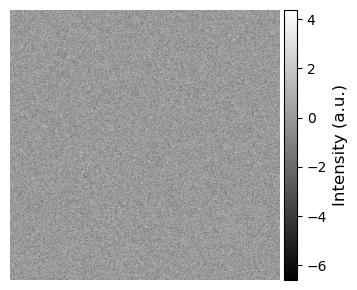

In [10]:
# Initialize Noise Shaper
emg_shaper = NoiseShaper(verbose=2)

# Set the parameters of the Exponentially Modified Gaussian
emg_shaper.set_exp_mod_gaussian_shape(*emg_params)

# Create the noise sample:
sample = emg_shaper.sample(shape = (480,480), n = 1)

# Check the generated noise image:
fig = emg_shaper.plot_image()

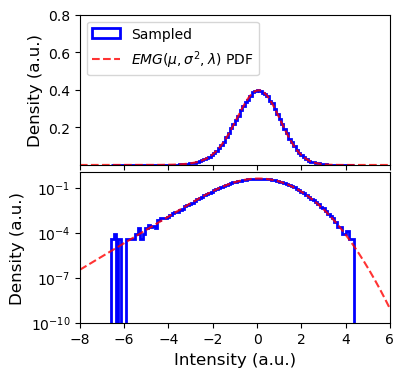

In [11]:
# To inspect the generated sample against the Probability Density Function, use:
fig = emg_shaper.plot_density()

## Noise Shaper: Skew-Normal

NoiseShaper initialized
Setting shape to Gaussian
Setting shape to Skew-Normal
Setting shape to Skew-Normal


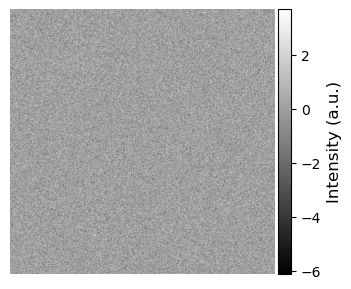

In [12]:
# Initialize Noise Shaper
skew_shaper = NoiseShaper(verbose=2)

# Set the parameters of the Skew-Normal
skew_shaper.set_skew_normal_shape(*skew_params)

# Or, one can also set them manually:
amp   =  0.99957600  # Amplitude
loc   =  0.85578852  # Location
scale =  1.31405641  # Scale
alpha = -1.41129763  # Skewness
#[0.99910547, 0.80027022, 1.27628502, -1.27311252]
skew_shaper.set_skew_normal_shape(amp, loc, scale, alpha)

# Create the noise sample:
sample = skew_shaper.sample(shape = (480,480), n = 1)

# Check the generated noise image:
fig = skew_shaper.plot_image()

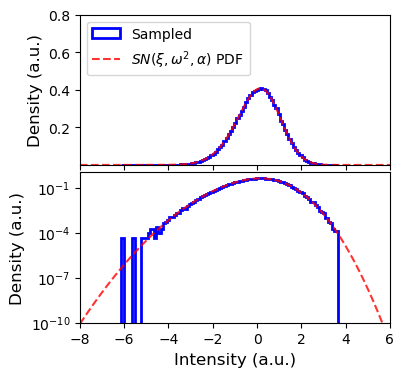

In [13]:
# Inspect sample against the PDF:
fig = skew_shaper.plot_density()

## Storing/Loading class

In [14]:
# Save noise shaper
skew_shaper.save("data/pickle/noise_shape.pkl")

# Load noise shaper
skew_shaper = NoiseShaper().load("data/pickle/noise_shape.pkl")

Saving NoiseShaper object  to  data/pickle/noise_shape.pkl
Loaded NoiseShaper object from data/pickle/noise_shape.pkl
